## Cardiovascular Disease Prediction
The primary goal of this project is to analyze the cardiovascular disease dataset and build a logistic regression model that predicts the likelihood of developing coronary heart disease within the next 10 years.
The structure is roughly as follows:

1. Data loading and cleaning
2. Exploratory Data Analysis
3. Modelling

In [274]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from scipy.stats import pearsonr, chi2_contingency, pointbiserialr
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

<!-- -->

## Data Loading and Cleaning

In [275]:
Cardiovascular_Disease_path = '/workspaces/157886021/CSV_FILES/train.csv'
df = pd.read_csv(Cardiovascular_Disease_path, index_col='id')
df.shape

(3390, 16)

I dropped the 'education' column as it does not provide any relevant information regarding the person's health.

In [276]:
df = df.drop(columns='education')

I checked for any duplicate rows and identified rows with missing values.

In [277]:
duplicates = df.duplicated().sum()
print(f"There are {duplicates} duplicate rows in the dataset.")

There are 0 duplicate rows in the dataset.


In [278]:
df.isna().mean()

age                         0.000000
sex                         0.000000
is_smoking                  0.000000
cigsPerDay                  0.006490
BPMeds                      0.012979
prevalentStroke             0.000000
prevalentHyp                0.000000
diabetes                    0.000000
totChol                     0.011209
systolic_blood_pressure     0.000000
diastolic_blood_pressure    0.000000
BMI                         0.004130
heartRate                   0.000295
glucose                     0.089676
TenYearCHD                  0.000000
dtype: float64

Since some of the 'BPMeds' values are blank and the data is binary, we will assume that the missing values were intended to be 0.

In [279]:
df['BPMeds'] = df['BPMeds'].fillna(0)

With around 400 rows containing missing values, which accounts for approximately 11% of the dataset, dropping them is not a viable option. Therefore, we used the KNN (k-nearest neighbors) algorithm to impute the missing values.

In [280]:
columns_to_impute = ['cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

imputed_data = knn_imputer.fit_transform(df[columns_to_impute])

df[columns_to_impute] = imputed_data

The number of 0s in each column is reasonable, as most of these columns are binary (0 or 1). For instance, 'cigsPerDay' can easily be 0 if the person does not smoke.

In [281]:
df.apply(lambda x: x == 0).mean()

age                         0.000000
sex                         0.000000
is_smoking                  0.000000
cigsPerDay                  0.502655
BPMeds                      0.970501
prevalentStroke             0.993510
prevalentHyp                0.684661
diabetes                    0.974336
totChol                     0.000000
systolic_blood_pressure     0.000000
diastolic_blood_pressure    0.000000
BMI                         0.000000
heartRate                   0.000000
glucose                     0.000000
TenYearCHD                  0.849263
dtype: float64

I converted the 'is_smoking' column into a numerical variable to assess its correlation with the dependent variable.

In [282]:
df['is_smoking'] = df['is_smoking'].map({'YES': 1, 'NO': 0})

I converted the 'sex' column into a numerical variable to assess its correlation with the dependent variable.

In [283]:
df['sex'] = df['sex'].map({'F': "1", 'M': "0"})

<!-- -->

## Exploratory Data Analysis

First, let's examine the dependent variable in this analysis, TenYearCHD.

Around 15% of people in this dataset are likely to have coronary heart disease in the next 10 years

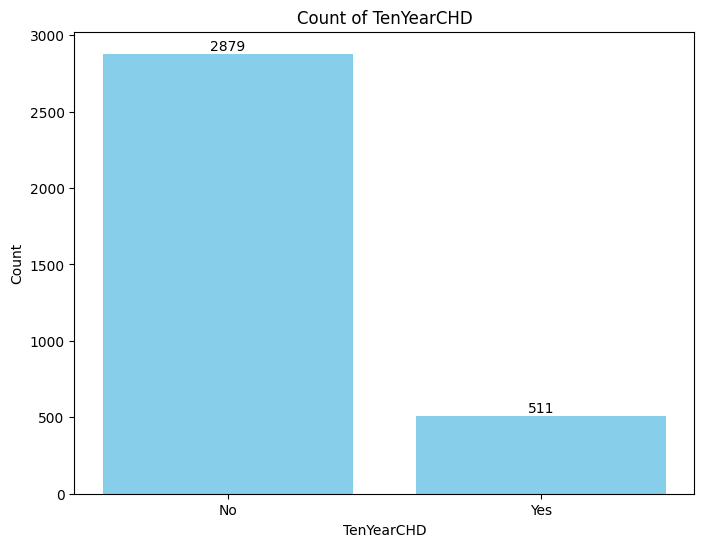

In [284]:
value_counts = df["TenYearCHD"].value_counts()

plt.figure(figsize=(8, 6))

# Create the bar plot
bars = plt.bar(value_counts.index, value_counts.values, color=['skyblue'])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f"{int(bar.get_height())}",
             ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('TenYearCHD')
plt.ylabel('Count')
plt.title('Count of TenYearCHD')
plt.xticks(value_counts.index, ['No', 'Yes'])
plt.show()



We can see in the plot above, that there is a class imbalance, therefore a in the modelling part, we will fix this issue.

In [285]:
print(df['TenYearCHD'].value_counts())


TenYearCHD
0    2879
1     511
Name: count, dtype: int64


Approximately 56% of individuals in this dataset are women, while 44% are men. This gender distribution may introduce potential bias in the findings, which should be considered when interpreting the results.

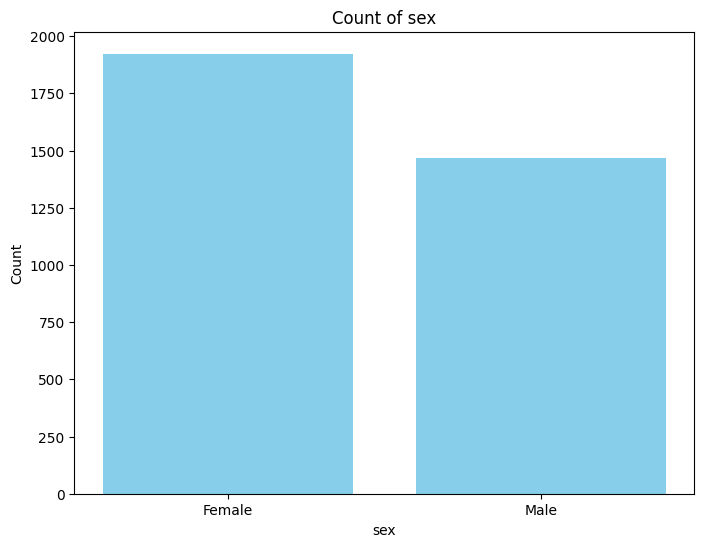

In [286]:
value_counts = df["sex"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['skyblue'])
plt.xlabel('sex')
plt.ylabel('Count')
plt.title('Count of sex')
plt.xticks(value_counts.index, ['Female', 'Male'])
plt.show()


We create a correlation matrix to identify columns that may be excluded from the logistic regression, this would help to avoid multicollinearity.

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

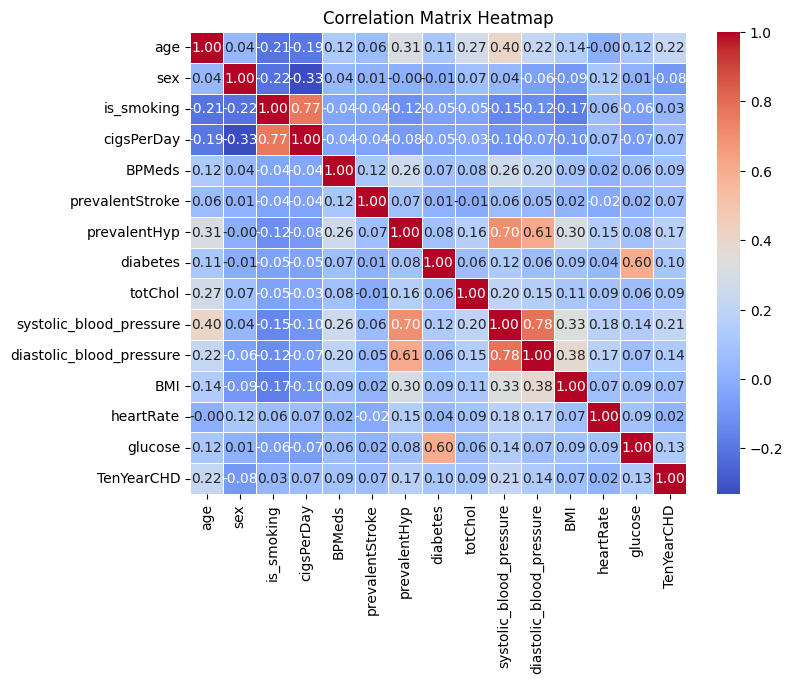

In [287]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title("Correlation Matrix Heatmap")

Upon reviewing the variables, we observed that both systolic and diastolic blood pressure provide similar information. Therefore, we will check their correlation to avoid the multicollinearity problem.

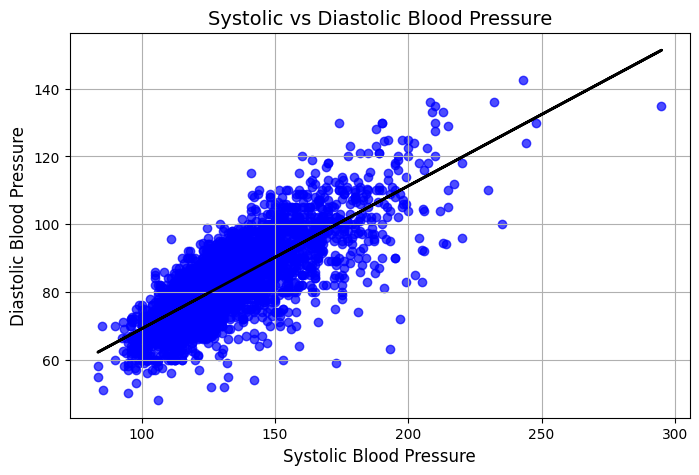

Correlation: 0.7819075063169497


In [288]:
plt.figure(figsize=(8, 5))
plt.scatter(df['systolic_blood_pressure'], df['diastolic_blood_pressure'], color='blue', alpha=0.7)

slope, intercept = np.polyfit(df['systolic_blood_pressure'], df['diastolic_blood_pressure'], 1)
plt.plot(df['systolic_blood_pressure'], slope * df['systolic_blood_pressure'] + intercept, color='black', linewidth=2)

plt.title('Systolic vs Diastolic Blood Pressure', fontsize=14)
plt.xlabel('Systolic Blood Pressure', fontsize=12)
plt.ylabel('Diastolic Blood Pressure', fontsize=12)
plt.grid(True)
plt.show()

correlation = df['systolic_blood_pressure'].corr(df['diastolic_blood_pressure'])
print(f"Correlation: {correlation}")

The graph specifies that there is a strong correlation between the variables. To avoid multicollinearity, we will retain only one of them in the dataset. The variable with the higher correlation coefficient to the dependent variable will be kept.

In [289]:
correlation_systolic = df['systolic_blood_pressure'].corr(df['TenYearCHD'])
correlation_diastolic = df['diastolic_blood_pressure'].corr(df['TenYearCHD'])

print(f"Correlation with CHD risk (Systolic): {correlation_systolic}")
print(f"Correlation with CHD risk (Diastolic): {correlation_diastolic}")

Correlation with CHD risk (Systolic): 0.21270292021881648
Correlation with CHD risk (Diastolic): 0.13597864735577808


As the Systolic blood pressure has a higher correlation with the dependent value TenYearCHD we will drop the diastolic blood pressure column.

leave p value to correlations

In [290]:
df = df.drop(columns='diastolic_blood_pressure')

The same goes for the 'is_smoking' and 'cigsPerDay' variables, as they show more or less the same information. We need to check the correlation between them and retain the one with the higher correlation coefficient to the dependent variable. For this, we used the Point-Biserial Correlation method.

In [291]:
correlation, p_value = pointbiserialr(df['cigsPerDay'], df['TenYearCHD'])
print(f"Point-Biserial Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.07
P-value: 0.0001


In [292]:
correlation, p_value = pointbiserialr(df['is_smoking'], df['TenYearCHD'])
print(f"Point-Biserial Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.03
P-value: 0.0468


Based on this analysis, we conclude that 'cigsPerDay' shows a stronger correlation with the dependent variable, TenYearCHD, as indicated by a higher Point-Biserial Correlation. Consequently, the 'is_smoking' column is dropped.

In [293]:
df = df.drop(columns='is_smoking')

Similarly, for the 'diabetes' and 'glucose' variables, as they also show similar information, we will check the correlation between them and keep the one with the higher correlation coefficient to the dependent variable. Again, we used the Point-Biserial Correlation method.

In [294]:
correlation, p_value = pointbiserialr(df['glucose'], df['TenYearCHD'])
print(f"Point-Biserial Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.13
P-value: 0.0000


In [295]:
correlation, p_value = pointbiserialr(df['diabetes'], df['TenYearCHD'])
print(f"Point-Biserial Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.10
P-value: 0.0000


Based on this analysis, we conclude that 'glucose' shows a stronger correlation with the dependent variable, TenYearCHD, as indicated by a higher Point-Biserial Correlation. Consequently, the 'diabetes' column is dropped.

In [296]:
df = df.drop(columns='diabetes')

Since systolic blood pressure is a key factor in determining prevalent hypertension (prevalentHyp), with high systolic blood pressure often indicating hypertension, it's no surprise that these two variables are highly correlated. We will retain the variable with the higher correlation coefficient to the dependent variable, using the Point-Biserial Correlation method for this decision.


In [297]:
correlation, p_value = pointbiserialr(df['systolic_blood_pressure'], df['TenYearCHD'])
print(f"Point-Biserial Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.21
P-value: 0.0000


In [298]:
correlation, p_value = pointbiserialr(df['prevalentHyp'], df['TenYearCHD'])
print(f"Point-Biserial Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.17
P-value: 0.0000


Based on this analysis, we conclude that 'systolic_blood_pressure' shows a stronger correlation with the dependent variable, TenYearCHD, as indicated by a higher Point-Biserial Correlation. Consequently, the 'prevalentHyp' column is dropped.

In [299]:
df = df.drop(columns='prevalentHyp')

We will classify the data into catergorical feats and numerical feats

In [300]:
categorical_feats = ['sex','BPMeds', 'prevalentStroke']
numerical_feats = ['age','cigsPerDay', 'totChol', 'systolic_blood_pressure', 'BMI', 'heartRate', 'glucose']

<!-- -->

The box plot shows that there are a significant number of outliers in these variables. However, instead of dropping them, we will treat them as anomalies and include them in our analysis.

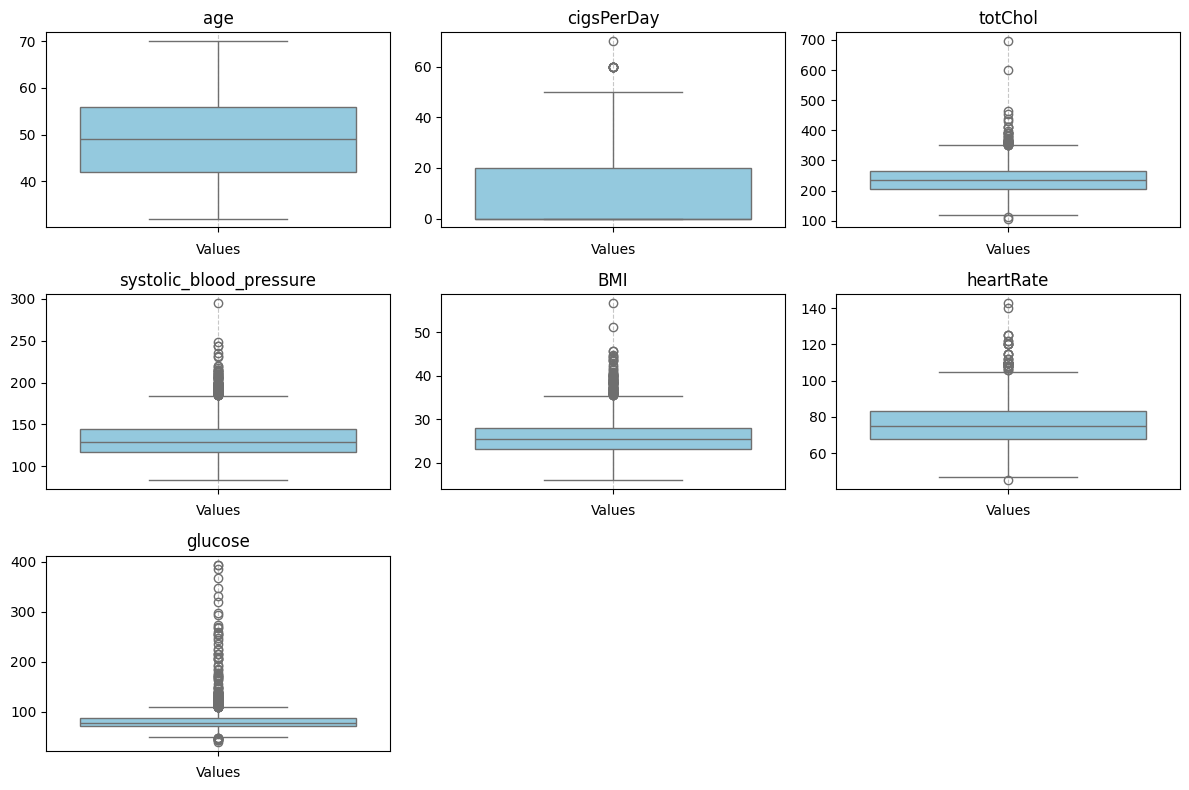

In [301]:
n_cols = 3
n_rows = -(-len(numerical_feats) // n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()


for i, var in enumerate(numerical_feats):
    sns.boxplot(data=df, y=var, ax=axes[i], color='skyblue')
    axes[i].set_title(f"{var}")
    axes[i].set_xlabel("Values")
    axes[i].set_ylabel("")
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

We aim to analyze the distribution of categorical features and assess their significance in relation to the dependent variable.

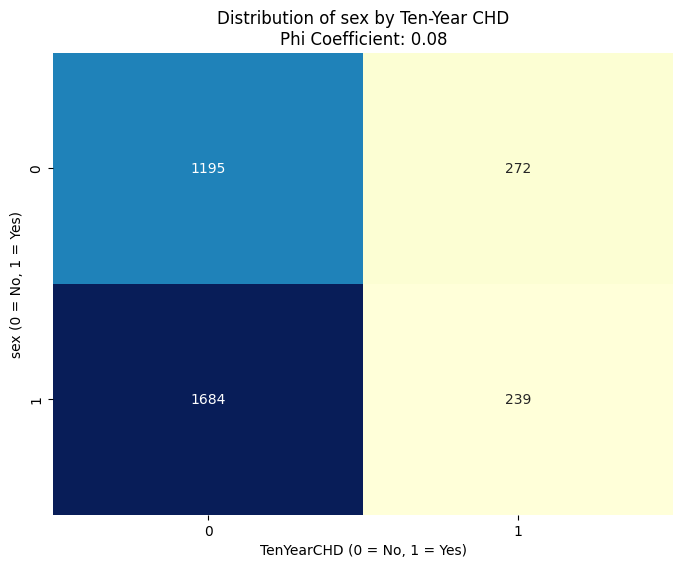

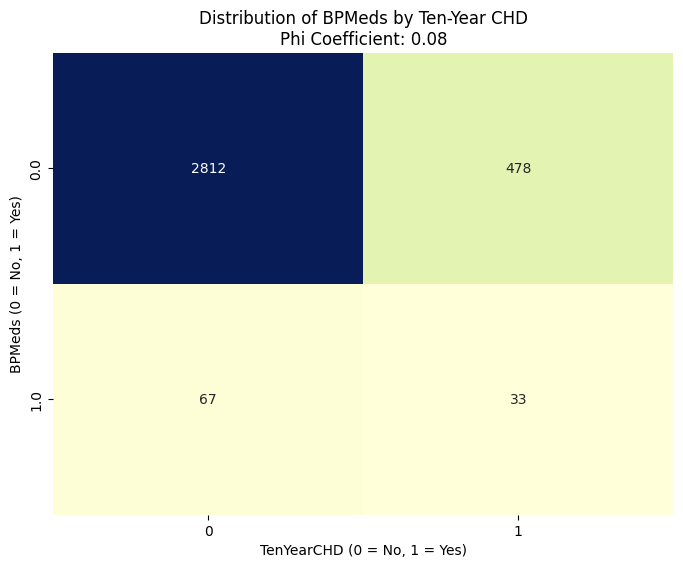

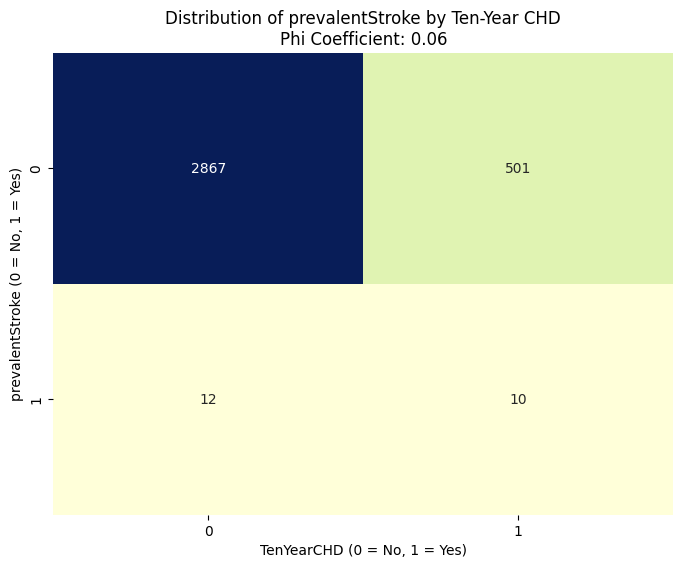

In [302]:
for var in categorical_feats:
    crosstab_counts = pd.crosstab(df[var], df['TenYearCHD'])

    chi2, p, dof, expected = chi2_contingency(crosstab_counts)

    phi = sqrt(chi2 / sum(crosstab_counts.sum()))

    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab_counts, annot=True, fmt='d', cmap='YlGnBu', cbar=False)

    plt.title(f'Distribution of {var} by Ten-Year CHD\nPhi Coefficient: {phi:.2f}')
    plt.xlabel('TenYearCHD (0 = No, 1 = Yes)')
    plt.ylabel(f'{var} (0 = No, 1 = Yes)')

All categorical features have correlation values ranging between 0.06 and 0.08, indicating a very weak positive relationship with the dependent variable. This suggests a slight tendency for these variables to be related in the same direction.

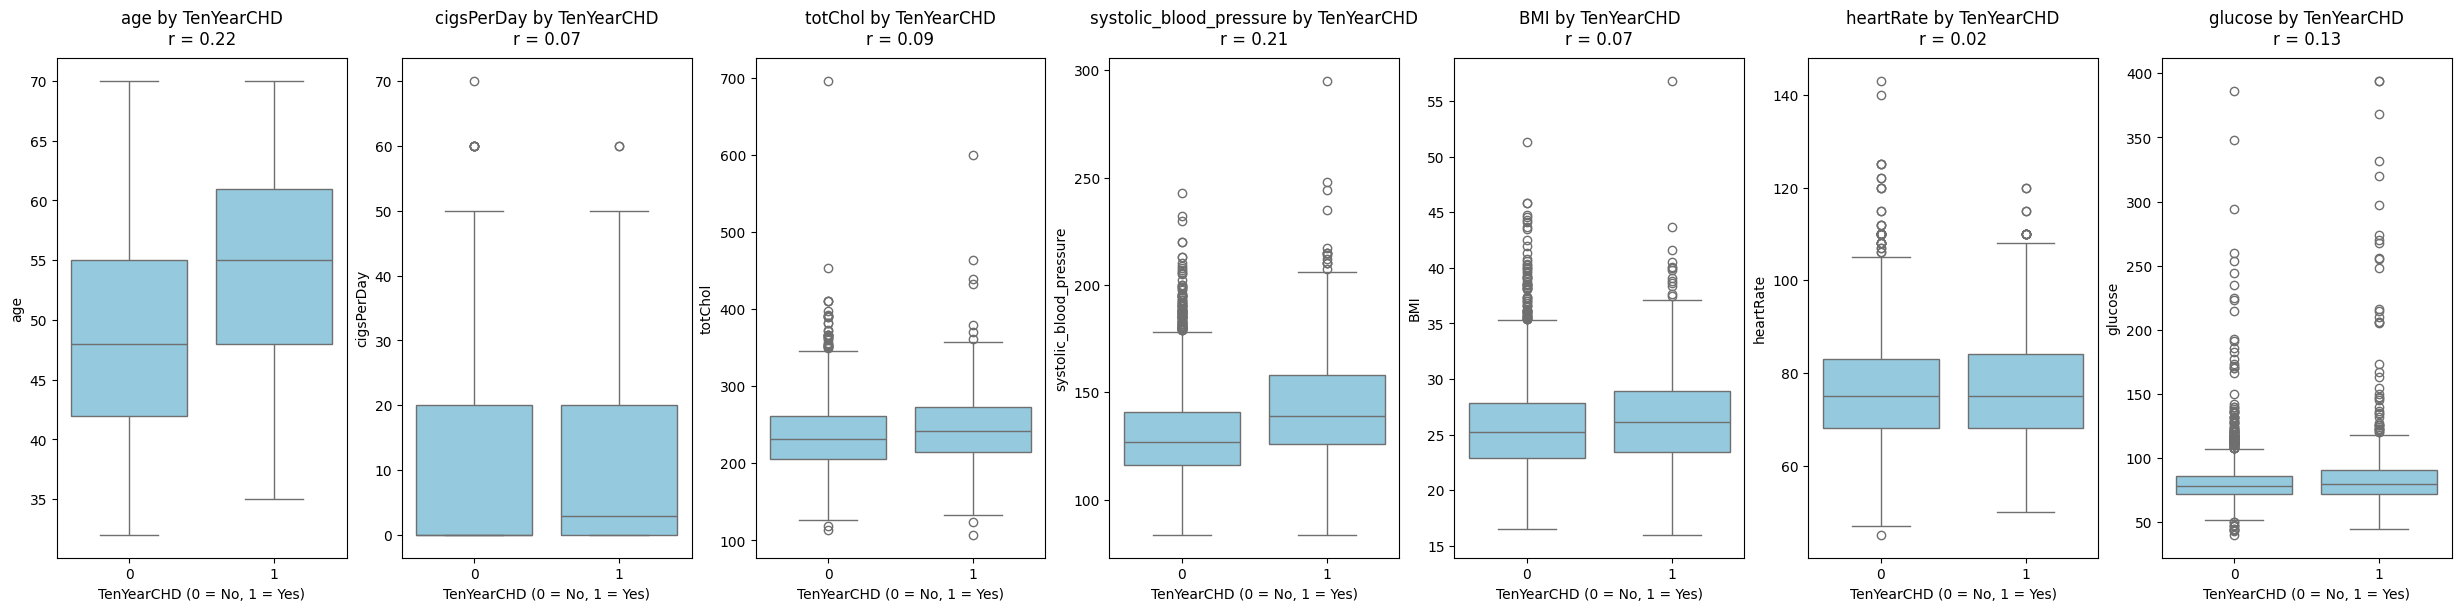

In [241]:
fig, axs = plt.subplots(1, len(numerical_feats), figsize=(3.5 * len(numerical_feats), 6), constrained_layout=True)

for i, feat in enumerate(numerical_feats):
    corr, _ = pointbiserialr(df['TenYearCHD'], df[feat])

    sns.boxplot(x='TenYearCHD', y=feat, data=df, ax=axs[i], color='skyblue')

    axs[i].set_title(f'{feat} by TenYearCHD\nr = {corr:.2f}', fontsize=12, pad=10)
    axs[i].set_xlabel('TenYearCHD (0 = No, 1 = Yes)', fontsize=10)
    axs[i].set_ylabel(feat, fontsize=10)

The correlation between the numerical features and the dependent variable reveals that the strongest relationships are with age (0.22) and systolic blood pressure (0.21).

<!-- -->

We should also check the skewness of the numerical variables. For any variable with skewness greater than 1, we will apply a log transformation to reduce the skewness.

In [242]:
skewness = df[numerical_feats].skew()
print(skewness)

age                        0.225796
cigsPerDay                 1.219893
totChol                    0.944424
systolic_blood_pressure    1.175837
BMI                        1.022704
heartRate                  0.676286
glucose                    6.278900
dtype: float64


The log transformation will be applied to the following variables: cigsPerDay, BMI, systolic_blood_pressure, glucose to reduce their skewness.

After careful evaluation, only 11 out of the original 16 variables were retained. These will be used in the 'Modeling' part.

In [ ]:
df.shape

(3390, 11)

In [305]:
df.sample(5)

,age,sex,cigsPerDay,BPMeds,prevalentStroke,totChol,systolic_blood_pressure,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,
780,39,1,0.0,0.0,0,185.0,109.0,29.68,63.0,93.0,0
1067,56,1,0.0,0.0,0,225.0,113.0,27.51,86.0,104.0,0
2658,50,1,10.0,0.0,0,220.0,122.0,24.22,75.0,72.0,0
3039,62,1,0.0,0.0,0,266.0,124.0,22.90,66.0,82.0,1
1695,59,1,0.0,0.0,0,224.6,153.5,26.08,71.0,113.0,0


To finish with the Exploratory Data Analysis part lets understand the retained variables better:

Categorical values: 
1. sex - Represents gender (e.g., Male - 0, Female - 1).
2. BPMeds - Indicates whether the person is on blood pressure medication (e.g., Yes, No).
3. prevalentStroke - Indicates whether the person has a history of stroke (e.g., Yes, No).
4. TenYearCHD - Indicates whether the person is likely to have coronary heart disease in the next 10 years (e.g., Yes, No) (Our dependent variable).

Continuous Variables (Non-Categorical):
1. age - The age of the person (numerical, continuous).
2. cigsPerDay - The number of cigarettes smoked per day (numerical, continuous).
3. totChol - Total cholesterol level (numerical, continuous).
4. systolic blood pressure - Systolic blood pressure measurement (numerical, continuous).
5. BMI - Body mass index (numerical, continuous).
6. heartRate - The heart rate of the person (numerical, continuous).
7. glucose - Blood glucose level (numerical, continuous).

<!-- -->

## Modelling

It's time to fit the linear regression model!

In [245]:
X = df[categorical_feats + numerical_feats]
y = df['TenYearCHD']

Next, I will split the data into a training set and a test set. The test set will be used at the very end of the notebook to evaluate the accuracy of the model.

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

/home/ubuntu/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

Here we have to use a standard scaler to standardize the range of independent variables.

In [247]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['cigsPerDay', 'BMI', 'systolic_blood_pressure', 'glucose']

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

We have to check VIF(Variance Inflation Factor) to avoid multicolinearity:

In [250]:

X = df[['age','cigsPerDay', 'totChol', 'systolic_blood_pressure', 'BMI', 'heartRate', 'glucose','BPMeds', 'prevalentStroke']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['TenYearCHD'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                TenYearCHD         VIF
0                    const  119.760491
1                      age    1.305868
2               cigsPerDay    1.054492
3                  totChol    1.103523
4  systolic_blood_pressure    1.446881
5                      BMI    1.135120
6                heartRate    1.058164
7                  glucose    1.034963
8                   BPMeds    1.087698
9          prevalentStroke    1.018515


In this case, VIF values don’t indicate a serious multicollinearity issue. therefore there is no need to take any corrective actions.

Finally it is time to fit a model!

In [ ]:
lr= LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

/home/ubuntu/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [311]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [312]:
coefficients = pipeline.named_steps['lr'].coef_
feature_names = X.columns
coeff_df = pd.DataFrame(coefficients, columns=feature_names, index=['Coefficient'])

print(coeff_df)

                const       age  cigsPerDay   totChol  \
Coefficient -0.251578  0.016012    0.107468  0.576002   

             systolic_blood_pressure       BMI  heartRate   glucose    BPMeds  \
Coefficient                 0.274318  0.074006   0.334574 -0.020135 -0.074828   

             prevalentStroke  
Coefficient           0.2164  


These coefficients represent the change in the log-odds of the dependent variable (TenYearCHD) for a one-standard-deviation increase in the independent variable (only for those whomst scaler was applied). For example, the coefficient for the sex variable indicates that, holding all other variables constant, a one-standard-deviation increase in the feature sex (const) (from male to female) decreases the log-odds of having a cardiovascular event by 0.2516. This means that, after scaling, being female (sex = 1) results in lower odds of experiencing a cardiovascular event in the next 10 years compared to males (sex = 0).

To make this interpretation more intuitive, we can transform the coefficient into an odds ratio, which will show the relative odds of the event happening for females compared to males, considering the scale of the sex feature.

In [267]:
sex_coef = -0.251578

odds_ratio = np.exp(sex_coef)
percent_change_in_odds = odds_ratio - 1

print(f"Odds Ratio for sex: {odds_ratio:.2f}")
print(f"Percentage change in odds: {percent_change_in_odds*100:.2f}%")

Odds Ratio for sex: 0.78
Percentage change in odds: -22.24%


If sex = 1 (female), the odds of having cardiovascular disease in the next 10 years are approximately 22% lower compared to males (sex = 0), assuming all other factors remain constant. It's important to note that this reflects a difference in odds, not direct probabilities.

However, since there are more females than males in this dataset, the findings might be skewed or less reliable for males due to potential class imbalance. This imbalance could affect how well the model generalizes to males and may introduce bias in the interpretation of the coefficient for sex. Lets try another variable.

In [270]:
age_coef = 0.016012

odds_ratio = np.exp(age_coef)
percent_change_in_odds = odds_ratio - 1

print(f"Odds Ratio for age: {odds_ratio:.2f}")
print(f"Percentage change in odds: {percent_change_in_odds*100:.2f}%")

Odds Ratio for age: 1.02
Percentage change in odds: 1.61%


The odds of experiencing a cardiovascular event in the next 10 years increase by approximately 1.61% each year, assuming all other factors remain constant. This reflects a change in the odds, not a direct probability. Lets try another variable.

In [273]:
systolic_blood_pressure_coef = 0.274318

odds_ratio = np.exp(systolic_blood_pressure_coef)
percent_change_in_odds = odds_ratio - 1

print(f"Odds Ratio for systolic_blood_pressure_coe (scaled): {odds_ratio:.2f}")
print(f"Percentage change in odds (per std dev increase): {percent_change_in_odds*100:.2f}%")

Odds Ratio for systolic_blood_pressure_coe (scaled): 1.32
Percentage change in odds (per std dev increase): 31.56%


The odds of experiencing a cardiovascular event in the next 10 years increase by approximately 31.56% for each standard deviation increase in systolic_blood_pressure, assuming all other factors remain constant. This reflects a change in the odds, not a direct probability.

<!-- -->

# Fit first model

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       868
           1       0.78      0.09      0.17       149

    accuracy                           0.86      1017
   macro avg       0.82      0.54      0.55      1017
weighted avg       0.85      0.86      0.81      1017



The main issue with our model is obvious - very low recall for the positive class. That is, out of all people with who have 10 year risk of heart disease, our model identifies only 9%. Some of that is what I already mentioned - humans are complex and predicting disease is hard. But we can also try to create a better model.

But how do we check if it is actually improving? We cannot just test it on the training data, since we can get arbitrarily good performance on the training data by overfitting. We cannot use the test data since that is for reporting the performance oft the final model.

This is where cross validation is very useful. First, let's find the cross-validated performance of our current model.

In [256]:
cv = cross_validate(
    model, X_train, y_train, cv=20, scoring=["accuracy", "precision", "recall", "f1_macro"]
)

/home/ubuntu/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

In [318]:
def print_cv_metrics(cv):
    df = pd.DataFrame(cv)
    df = df.drop(columns=["fit_time", "score_time"])
    df = df.melt(var_name="metric", value_name="score").groupby("metric").mean().round(3)
    print(df)

In [319]:
print_cv_metrics(cv)

                score
metric               
test_accuracy   0.631
test_f1_macro   0.547
test_precision  0.243
test_recall     0.663


Now let's create a new model that addresses the imbalance issue. There are many techniques for this, but logistic regression implementation in scikit-learn is quite neat because it has the class_weight parameter. By setting this parameter to balanced, we're telling the model to assign bigger weights to the underrepresented class during training.

In [259]:
model_balanced = LogisticRegression(fit_intercept=True, max_iter=10000, class_weight="balanced")

In [322]:
cv_balanced = cross_validate(
    model_balanced, X_train, y_train, cv=20, scoring=["accuracy", "precision", "recall", "f1_macro"]
)

In [323]:
print_cv_metrics(cv_balanced)

                score
metric               
test_accuracy   0.668
test_f1_macro   0.576
test_precision  0.265
test_recall     0.666


Looking at the F1 Macro metric, we see that setting the class_weight parameter to balanced improved model performance by 3 percentage points. That's a modest gain, but a gain nonetheless.

We could keep improving the model pretty much endlessly, each time checking the cross validation metrics. For instance, we could experiment with regularization) by searching for the penalty parameter with the best cross validation score (by default LogisticRegression uses l2 regularization). The process of finding optimal model parameters is called hyperparameter tuning.

# Evaluation of the model

In [324]:
model_balanced.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [326]:
y_pred = model_balanced.predict(X_test)

In [326]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79       868
           1       0.27      0.64      0.38       149

    accuracy                           0.69      1017
   macro avg       0.59      0.67      0.59      1017
weighted avg       0.82      0.69      0.73      1017



The model showed significant improvement in recall specifically for predicting class 1. It's also beneficial to examine the confusion matrix for a comprehensive view.

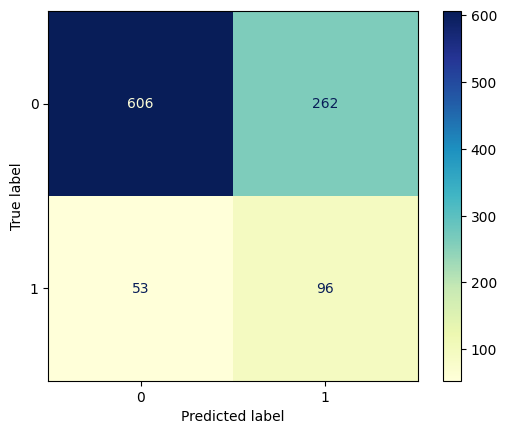

In [327]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='YlGnBu')

Indeed, predicting heart disease is hard and we've only been able to achieve F1 Macro performance of 0.59. We most probably could improve the model further via hyperparameter tuning and feature engineering, or by experimenting with other kinds of algorithms, such as random forests.

<!-- -->

## Improvements

1. **Feature Engineering:**
Create New Features: Convert continuous age into categories to capture different health risks for different age ranges. Risk Categories: Convert continuous health data (like BMI) into categorical risk groups (Underweight', 'Overweight etc.).

2. **Addressing Class Imbalance:**
Ensure equal representation of females and males for a more realistic analysis and to avoid biased results, oversampling cound fix this isssue.

3. **Have More Data:**
Having more relevant data, such as a larger number of cases with Coronary Heart Disease, would enhance our models and typically improve both the quality and accuracy of the predictions.

4. **Missing Data Imputation:**
Missing data imputation needs to be performed more carefully. Most of the missing data was based on typos and the application of k-nearest neighbors. If the data were imputed correctly, some of the findings might have been different.

## Conclusion

The cardiovascular disease prediction model developed in this project provides valuable insights into the potential risk factors associated with heart disease. By leveraging various health-related features, including both categorical and numerical data, the model offers a prediction of disease likelihood that could aid in early detection and preventive healthcare measures.

However, there are some limitations, including the potential gender bias due to the uneven distribution of male and female participants in the dataset. Further efforts to balance the dataset and incorporate additional relevant features could improve the model's accuracy and fairness. Additionally, the imputation of missing data and the choice of model parameters should be continuously refined to ensure the most reliable predictions.